In [15]:
# import modules

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.dummy import DummyClassifier
from sklearn import tree
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, precision_score, recall_score, confusion_matrix,
    plot_confusion_matrix, make_scorer,multilabel_confusion_matrix,ConfusionMatrixDisplay)

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

from xgboost import XGBClassifier

from CF_5_Modelling import (add_model_score, feat_imp, scorer_pos_neg_class,
                            scorer_confusion_matrix)

rng = 847666577 #int(np.random.default_rng().random()*(2**32))

%qtconsole

In [16]:
data_raw_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\water-pump-tanzania\\data\\raw\\'
data_interim_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\water-pump-tanzania\\data\\interim\\'
data_processed_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\water-pump-tanzania\\data\\processed\\'
docs_img_dir = 'C:\\Users\\bryan\\OneDrive\\02 GitHub\\water-pump-tanzania\\docs\\img\\'

In [26]:
df_train = pd.read_csv(data_processed_dir+'training_data_encoded_no-geo.csv')
print(df_train.shape)
print(df_train.columns)
df_train.head(2)

(57588, 70)
Index(['id', 'amount_tsh', 'longitude', 'latitude', 'district_code',
       'population', 'public_meeting', 'permit', 'pump_age', 'status_group',
       'installer_Commu', 'installer_DWE', 'installer_Government',
       'installer_RWE', 'installer_other', 'installer_unknown',
       'basin_Internal', 'basin_Lake Tanganyika', 'basin_Lake Victoria',
       'basin_Pangani', 'basin_Rufiji', 'basin_other', 'region_Iringa',
       'region_Kilimanjaro', 'region_Mbeya', 'region_Morogoro',
       'region_Shinyanga', 'region_other', 'extraction_type_class_gravity',
       'extraction_type_class_handpump', 'extraction_type_class_motorpump',
       'extraction_type_class_other', 'extraction_type_class_rope pump',
       'extraction_type_class_submersible',
       'extraction_type_class_wind-powered', 'management_other',
       'management_parastatal', 'management_private operator',
       'management_vwc', 'management_water board', 'management_wua',
       'management_wug', 'payment_ty

,id,amount_tsh,longitude,latitude,district_code,population,public_meeting,permit,pump_age,status_group,...,source_class_surface,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_hand pump,waterpoint_type_other,pump_age_0-20,pump_age_20-40,pump_age_40-60,pump_age_60-80,pump_age_80-100
0,69572,6000.0,34.938093,-9.856322,5,109,1,0,12.0,functional,...,0,1,0,0,0,0,1,0,0,0
1,8776,0.0,34.698766,-2.147466,2,280,1,0,3.0,functional,...,1,1,0,0,0,1,0,0,0,0


In [18]:
print(df_train['status_group'].value_counts(normalize=True))

functional                 0.545061
non functional             0.386678
functional needs repair    0.068261
Name: status_group, dtype: float64


In [20]:
df_col = df_train.columns.to_list()

X = df_train.drop(['id','status_group'],axis=1)

label_enc = LabelEncoder()

y = label_enc.fit_transform(df_train['status_group'])

label_dict = dict(zip(list(set(y)),label_enc.inverse_transform(list(set(y))).tolist()))

X.head()

,amount_tsh,longitude,latitude,district_code,population,public_meeting,permit,pump_age,installer_Commu,installer_DWE,...,source_class_surface,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_hand pump,waterpoint_type_other,pump_age_0-20,pump_age_20-40,pump_age_40-60,pump_age_60-80,pump_age_80-100
0,6000.0,34.938093,-9.856322,5,109,1,0,12.0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,0.0,34.698766,-2.147466,2,280,1,0,3.0,0,0,...,1,1,0,0,0,1,0,0,0,0
2,25.0,37.460664,-3.821329,4,250,1,1,4.0,0,0,...,1,0,1,0,0,1,0,0,0,0
3,0.0,38.486161,-11.155298,63,58,1,0,27.0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0.0,31.130847,-1.825359,1,0,1,0,23.0,0,0,...,1,1,0,0,0,0,0,1,0,0


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

print(pd.Series(y_train).value_counts().sort_index())

0    23519
1     2922
2    16750
dtype: int64


In [22]:
# SMOTE training editing
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_sample(X_train,y_train)

print(pd.Series(y_train_smote).value_counts())

0    23519
1    23519
2    23519
dtype: int64


## RFC Base

In [23]:
model = RandomForestClassifier(random_state=123,n_estimators=200)
scaler = StandardScaler()

grid_params = {
    'scaler' : [StandardScaler()], #,MinMaxScaler(),None
}

RFC_base_pipe = Pipeline([('scaler',scaler),('model',model)])

RFC_base_pipe.fit(X_train,y_train)

y_pred = RFC_base_pipe.predict(X_test)

recall weighted : 0.7960686254080711
accuracy : 0.7960686254080711


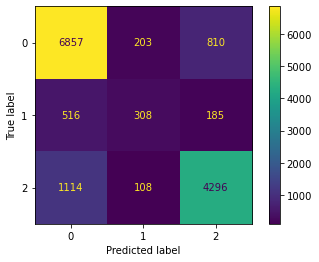

In [24]:
print('recall weighted : %s' % recall_score(y_test,y_pred,average='weighted'))
print('accuracy : %s' % accuracy_score(y_test,y_pred))
plot_confusion_matrix(RFC_base_pipe,X_test,y_test)

In [25]:
pd.Series(RFC_base_pipe.named_steps.model.feature_importances_, index=X.columns).sort_values(ascending=False)

longitude                             0.164087
latitude                              0.163641
quantity_dry                          0.078106
population                            0.059483
pump_age                              0.056970
                                        ...   
installer_Commu                       0.001138
payment_type_other                    0.001132
extraction_type_class_rope pump       0.000809
source_class_other                    0.000637
extraction_type_class_wind-powered    0.000321
Length: 68, dtype: float64

## XGBoost

In [134]:
model = XGBClassifier(objective='multi:softmax',booster='gbtree',use_label_encoder=False)

grid_params = {
    'model__learning_rate': [1], #np.arange(0.1,1,step=0.1),
    #'model__n_estimators': [35], #np.arange(30,50,step=1),
    #'model__max_depth' : np.arange(1,10,step=1),
    'model__gamma' : [0.6], #np.arange(0,1,step=0.1),
    'model__lambda' : np.arange(0,1.1,step=0.1),
    #'model__alpha' : [0], #np.arange(0,1.1,step=0.1),
    'scaler': [StandardScaler()] #, MinMaxScaler(),None]    
}

XGB_base_pipe = GridSearchCV(Pipeline([('scaler',scaler),('model',model)]),scoring='recall_weighted',cv=5,param_grid=grid_params,n_jobs=-1)

XGB_base_pipe.fit(X_train,y_train)

y_pred = XGB_base_pipe.predict(X_test)

[10:47:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [135]:
print('recall weighted : %s' % recall_score(y_test,y_pred,average='weighted'))
print('accuracy : %s' % accuracy_score(y_test,y_pred))
confusion_matrix(y_test,y_pred)

recall weighted : 0.500875656742557
accuracy : 0.500875656742557


array([[6129,   57, 1795],
       [ 793,    7,  249],
       [4480,   36, 1300]], dtype=int64)